# Time-Series and the Marchenko-Pastur pdf of covariance matrices

We are going to study the eigenvalues of large covariance matrices using Marchenko-Pastur probability density function of random matices.

<b>Motivation</b><br>
If we find signal in IMRs time-series, that is correlation between time-series, we can consider using neural-networks and other machine learning techniques to forcast a time seire at $Y(t+h)$ at time $t$ for some $h>0$.

From wikipedia: <br><i>
-In the mathematical theory of random matrices, the Marchenko–Pastur distribution, or Marchenko–Pastur law, describes the asymptotic behavior of singular values (non-negative eigenvalues *) of large rectangular random matrices. 

In particular for a correlation matrix - Let $X$ be independent and identically distributed random observations of size $TxN$ where the underlying process generating the observation has mean 0, and variance $\sigma^2$ then the correlation matrix, $C=T^{-1}X^TX$, has eigenvalues $\lambda$ distributed according to the Marchenko-Pastur distribution

\begin{equation*}
f(\lambda) = \frac{T}{N}\frac{\sqrt{( \lambda_+-\lambda )( \lambda_--\lambda )}}{2\pi\lambda\sigma^2}\unicode{x1D7D9}_{(\lambda_-,\lambda_+)}
\end{equation*}

where 
\begin{equation*}
\lambda_+ = \sigma^2(1+\sqrt{\frac{N}{T}})^2 \\
\lambda_- = \sigma^2(1-\sqrt{\frac{N}{T}})^2
\end{equation*}

When C is a correlation matrix, $\sigma^2<=1$ <br>

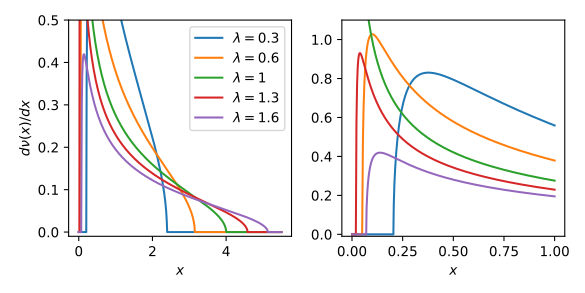

<b>Note:</b>Random matrix theory assumes no auto-correlation but there is a refinement called Autoregressiv random matrix theory (https://doi.org/10.1063/1.4975217)

\* Eigenvectors and singular vectors are them same if the matrix is a real symmetric matrix (e.g. covariance matrix)

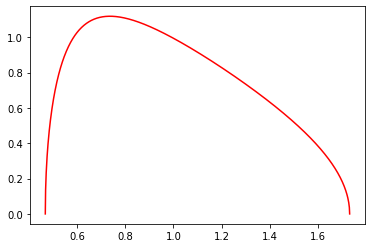

In [7]:
import numpy as np
import pandas as pd
from sklearn.neighbors import KernelDensity
import matplotlib.pylab as plt
from scipy.optimize import minimize

#Marcenko-Pastur pdf
#q=T/N 
def mpPDF(var, q, pts):
    eMin, eMax = var*(1-(1./q)**.5)**2, var*(1+(1./q)**.5)**2 # calc lambda_minus, lambda_plus
    eVal = np.linspace(eMin, eMax, pts) #Return evenly spaced numbers over a specified interval. eVal='lambda'
    pdf = q/(2*np.pi*var*eVal)*((eMax-eVal)*(eVal-eMin))**.5 #np.allclose(np.flip((eMax-eVal)), (eVal-eMin))==True
    pdf = pd.Series(pdf, index=eVal)
    return pdf

N = 1000
T = 10000
pdf0 = mpPDF(1., q=T/N, pts=N)
plt.plot(pdf0.keys(), pdf0, color='r', label="Marcenko-Pastur pdf")

## Correlation matrices
\begin{equation*}
corr(X,Y) = \frac{cov(X,Y)}{\sigma_x \sigma_y}
\end{equation*}

\begin{equation*}
cov(X,Y) = E[(X-E[X])(Y-E[Y])] = \sum_{i=0}^{i=n} \frac{(X_i-\mu_x)(Y_i-\mu_y)}{n-1}
\end{equation*}
Correlation is just covariance scaled to [-1,1]

The main idea with covariance is that it can identify relationships with positive, negative and no trend.
<img src="image_corr.png">
<!-- ![image.png](attachment:image.png) -->

We would like to use the Marchenko-Pastur distribution to find signal in sets of time-series data. First lets see how the eigenvalues distribution exactly in the case the Marchenko-Pastur pdf describing - when the correlation matrix is random. So we sample a random matrix from the normal distribution with mean 0, and variance 1.  

In [4]:
N = 1000 
T = 10000 
x = np.random.normal(0, 1, size = (T, N))
# x has 1000 indicators - one pr column - with rows=10.000 time-steps
cor = np.corrcoef(x, rowvar=0) 
print(cor.shape)

(1000, 1000)


Define a function getPCA to get the eigenvalues, and eigenvectors - sorted.

In [6]:
def getPCA(matrix):
    # Get eVal, eVec from a Hermitian matrix
    eVal, eVec = np.linalg.eig(matrix) #complex Hermitian (conjugate symmetric) or a real symmetric matrix.
    indices = eVal.argsort()[::-1] #arguments for sorting eval desc
    eVal,eVec = eVal[indices],eVec[:,indices]
    eVal = np.diagflat(eVal) # identity matrix with eigenvalues as diagonal
    return eVal,eVec

Lets find the eigenvalues and plot the histogram with MP pdf.

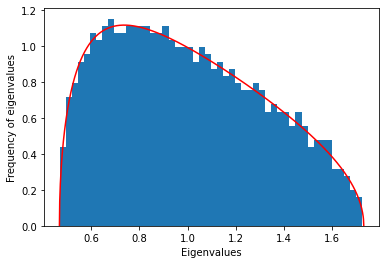

In [6]:
eVal0 , eVec0 = getPCA( cor ) 
pdf0 = mpPDF(1., q=x.shape[0]/float(x.shape[1]), pts=N)
fig = plt.figure()
ax  = fig.add_subplot(111)
ax.hist(np.diag(eVal0), density = True,bins=50) # Histogram the eigenvalues
plt.plot(pdf0.keys(), pdf0, color='r', label="Marcenko-Pastur pdf")
plt.ylabel("Frequency of eigenvalues")
plt.xlabel("Eigenvalues")
plt.show()

## Random walk

Lets define a random walk as a stocastic discrete-time process with a continous state-space. It is not a stationary process. 

Does two or more random walks have correlation?


Source:( https://towardsdatascience.com/animated-visualization-of-random-walks-in-python-dc18f01ef15e )

In [3]:
import numpy as np

def random_walk(N, seed):
    """
    Simulates a continuous random walk
    :param int N : the number of steps to take
    """
    np.random.seed(seed)
    
    # the epsilon values
    random_increments = np.random.normal(0, 1, size=N) #mu=0, var=1
    # calculate the random walk
    random_walk = np.cumsum(random_increments)
    
    # return the entire walk and the increments
    return random_walk, random_increments
  
  # generate a random walk
N = 50
X, epsilon = random_walk(N, 1234)

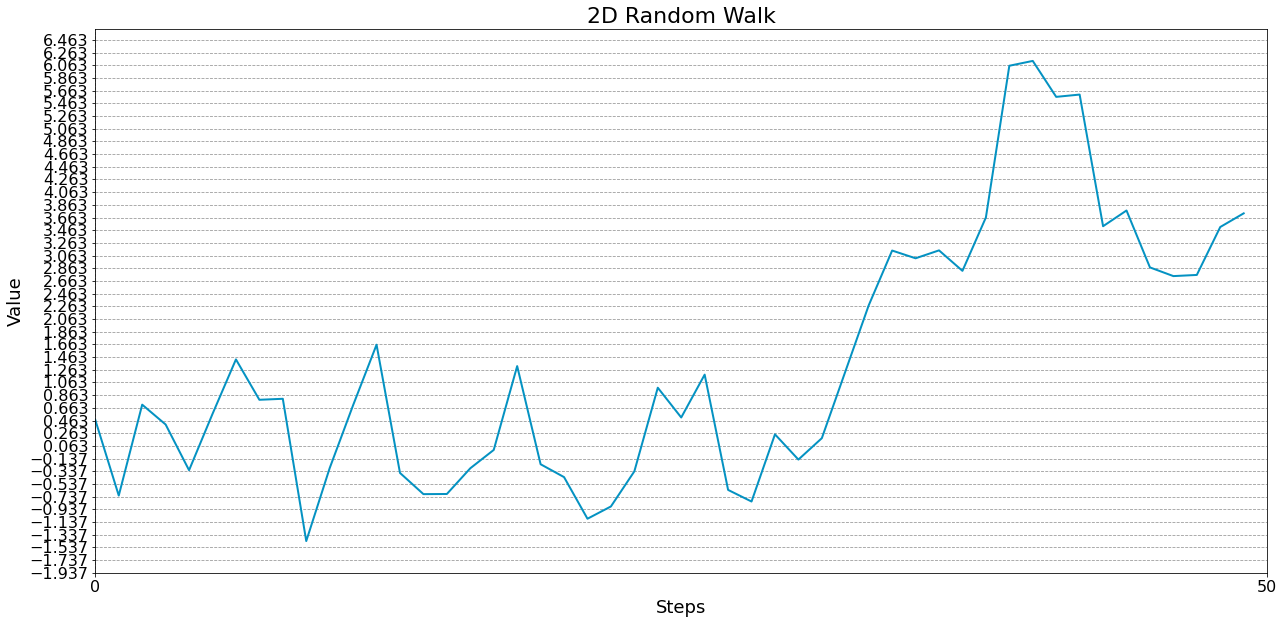

In [4]:
import matplotlib.pyplot as plt
import matplotlib.animation as animation
import networkx as nx
from matplotlib.animation import FuncAnimation, PillowWriter

fig = plt.figure(figsize=(21, 10))
ax = plt.axes(xlim=(0, N), ylim=(np.min(X) - 0.5, np.max(X) + 0.5)) 
line, = ax.plot([], [], lw=2, color='#0492C2')
ax.set_xticks(np.arange(0, N+1, 50))
ax.set_yticks(np.arange(np.min(X) - 0.5, np.max(X) + 0.5, 0.2))
ax.set_title('2D Random Walk', fontsize=22)
ax.set_xlabel('Steps', fontsize=18)
ax.set_ylabel('Value', fontsize=18)
ax.tick_params(labelsize=16)
ax.grid(True, which='major', linestyle='--', color='black', alpha=0.4)

# initialization function 
def init(): 
    # creating an empty plot/frame 
    line.set_data([], []) 
    return line, 

# lists to store x and y axis points 
xdata, ydata = [], []

# animation function 
def animate(i):
    y = X[i] #animate random walk
    # appending new points to x, y axes points list 
    xdata.append(i) 
    ydata.append(y) 
    line.set_data(xdata, ydata) 
    return line,

# call the animator	 
anim = animation.FuncAnimation(fig, animate, init_func=init, frames=N, interval=20, blit=True)
anim.save('random_walk.gif',writer=PillowWriter(fps=20)) #writer='imagemagick') 

30 largest eigenvalues from random walk correlation matrix
[  1.19715754   1.2755253    1.4027892    1.61557919   1.67802462
   1.75117811   1.8713399    2.09901171   2.30298901   2.32025626
   2.51292945   2.77347453   3.42469322   3.51159903   4.26334568
   4.65204882   5.56338354   6.55664369   7.53721128  10.09466695
  10.61595442  13.49520315  16.62376778  22.62683985  27.63782549
  42.92342463  58.54323963 101.97656794 159.62263396 442.96900928]
lambda_pluss from mp pdf
1.732455532033676


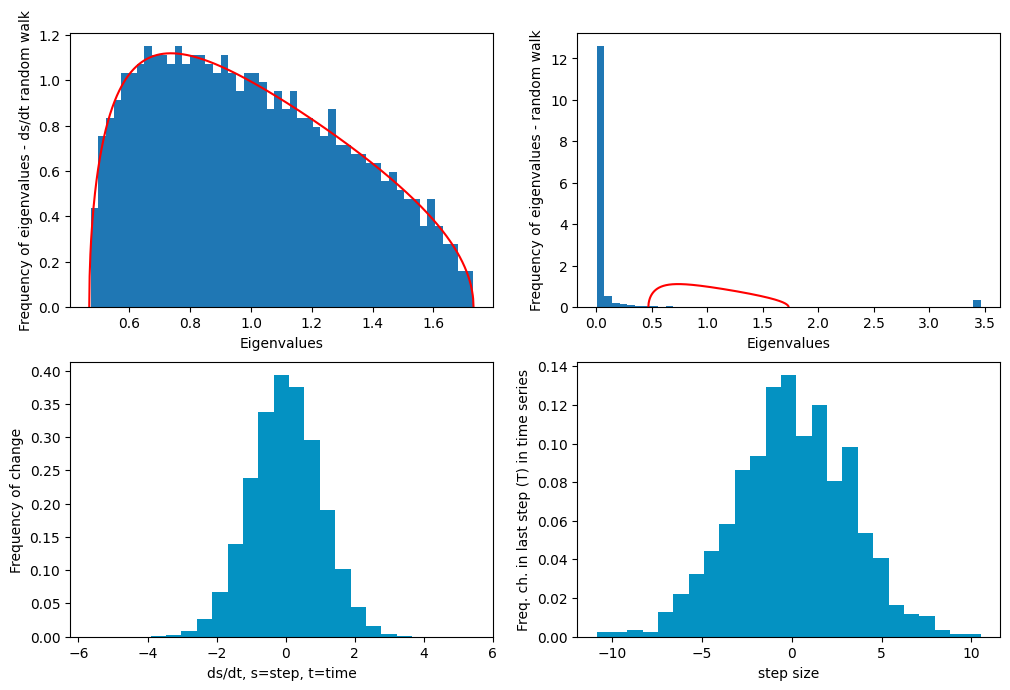

In [8]:
N=1000
T=10000
time_series = np.zeros(shape=(T,N))
change_series = np.zeros(shape=(T,N))
X_norm = [0] * N
dt= 1./N # the time step

changeCount=0
for i in range(0,N):
    time_series[:,i], _ = random_walk(T, i)
    X_norm[i] = time_series[T - 1, i] * np.sqrt(dt)

for i in range(0,N):
    changeCount=0
    for j in range(0,T):
        if j>0:
            change_series[j-1, i] = time_series[j, i] - time_series[j-1, i]

cor = np.corrcoef(time_series, rowvar=0) 
eVal0 , eVec0 = getPCA( cor  ) 

cor1 = np.corrcoef(change_series, rowvar=0) 
eVal_change , _ = getPCA( cor1  ) 
eVal_change = np.diag(eVal_change)

eVal0 = np.diag(eVal0)
print('30 largest eigenvalues from random walk correlation matrix')
print(np.sort(eVal0)[-30:])
q_ = time_series.shape[0]/float(time_series.shape[1])
var=1.
eMin, eMax = var*(1-(1./q_)**.5)**2, var*(1+(1./q_)**.5)**2
print('lambda_pluss from mp pdf')
print(eMax)

eVal1 = np.copy(eVal0)
for i in range(0, len(eVal0)):
    if eVal0[i] > eMax:
        eVal1[i] = 2*eMax


pdf0 = mpPDF(1., q=q_, pts=N)
fig = plt.figure(figsize=(12,8), dpi=100)
ax  = fig.add_subplot(221)
ax1 = plt.subplot(222)
ax2 = plt.subplot(223)
ax3 = plt.subplot(224)
ax.hist(eVal_change, density=True, bins=50)
ax.plot(pdf0.keys(), pdf0, color='r', label="Marcenko-Pastur pdf")
ax1.hist(eVal1, density = True, bins=50) # Histogram the eigenvalues
ax1.plot(pdf0.keys(), pdf0, color='r', label="Marcenko-Pastur pdf")
ax2.hist(change_series.flatten(), bins=25, density=True, color='#0492C2')
ax3.hist(X_norm, bins=25, density=True, color='#0492C2')

ax.set_ylabel("Frequency of eigenvalues - ds/dt random walk")
ax.set_xlabel("Eigenvalues")
ax1.set_ylabel("Frequency of eigenvalues - random walk")
ax1.set_xlabel("Eigenvalues")
ax2.set_ylabel("Frequency of change")
ax2.set_xlabel("ds/dt, s=step, t=time")
ax3.set_ylabel("Freq. ch. in last step (T) in time series")
ax3.set_xlabel("step size")
plt.show()


## Creating random matrix with signal

In [11]:
change_time_series = np.random.normal(0, 1, size = (T, N))
x = change_time_series

sin_np = np.sin([i for i in range(0,T)])
sin_plus_pi_fourth = sin_np + np.pi/4 #translate sine wave

x[:,0] = -sin_np #np.ones(T)
x[:,1] = -sin_np

print(x.shape)

(10000, 1000)


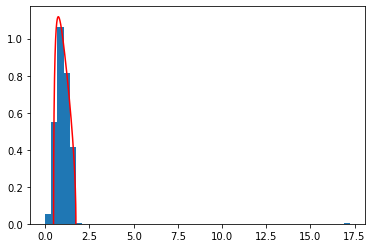

In [12]:
for j in range(2,11):
    x[:,j] += (2*sin_np) 
    
for j in range(11,20):
    x[:,j] = sin_plus_pi_fourth 

# indicator 0-20 has correlation
cor = np.corrcoef(x, rowvar=0) 

eVal0 , eVec0 = getPCA( cor ) 
pdf0 = mpPDF(1., q=x.shape[0]/float(x.shape[1]), pts=N)
fig = plt.figure()
ax  = fig.add_subplot(111)
ax.hist(np.diag(eVal0), density = True,bins=50) # Histogram the eigenvalues
plt.plot(pdf0.keys(), pdf0, color='r', label="Marcenko-Pastur pdf")
plt.show()

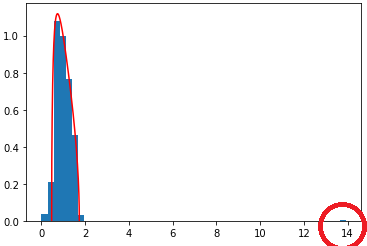

The histogram suggests there is some kind of correlation in the set of indicators (surprise!). Lets see if we can find where the signal is. 

We do this by clustering the correlation matrix using KMeans clustering and the silhouett method for finding the optimal numbers of clusters. KMeans takes as argument the number of clusters, but using the silhouett method we dont have to specify how many clusters there are. We would like the data to tell us.

The optimal number of clusters is found by maximizing withing group correlation and minimizing between group correlation.

In [13]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_samples
import seaborn as sns

#Use a silhouett method to find optimal number of clusters for KMeans clustering
def clusterKMeansBase(corr0, maxNumClusters=10, n_init=10):
    x, silh = ((1-corr0.fillna(0))/2.)**.5, pd.Series(dtype='float64') #observations matrix
    x, silh = ((1-corr0)/2.)**.5, pd.Series(dtype='float64') #observations matrix
    maxNumClusters = min(maxNumClusters, x.shape[0]-1)
    for init in range(n_init):
        for i in range(2, maxNumClusters+1):
            #print(i)
            kmeans_ = KMeans(n_clusters=i, n_init=1) #n_jobs=None, n_init=1) #n_jobs=None - use all CPUs
            kmeans_ = kmeans_.fit(x)
            silh_ = silhouette_samples(x, kmeans_.labels_)
            stat = (silh_.mean()/silh_.std(), silh.mean()/silh.std())
            if np.isnan(stat[1]) or stat[0] > stat[1]:
                silh, kmeans = silh_, kmeans_
    
    newIdx = np.argsort(kmeans.labels_)
    corr1 = corr0.iloc[newIdx] #reorder rows
    
    corr1 = corr1.iloc[:, newIdx] #reorder columns
    clstrs = {i:corr0.columns[np.where(kmeans.labels_==i)[0]].tolist() for i in np.unique(kmeans.labels_)} #cluster members
    silh = pd.Series(silh, index=x.index)
    
    return corr1, clstrs, silh

Lets apply it to the correlation matrix with signal.

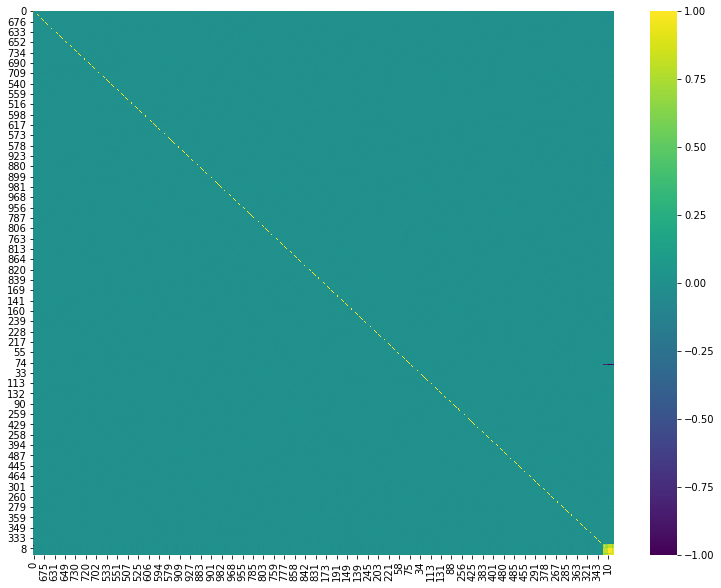

{0: [0, 1, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 181, 182, 183, 184, 185, 186, 187, 188, 189, 190, 191, 192, 193, 194, 195, 196, 197, 198, 199, 200, 201, 202, 203, 204, 205, 206, 207, 208, 209, 210, 211, 212, 213, 214, 215, 216, 217, 218, 219, 220, 221, 222, 223, 224, 225, 226, 227, 228, 229, 230, 231, 232, 233,

In [14]:
corr0, clstrs, silh = clusterKMeansBase(pd.DataFrame(cor), maxNumClusters=10, n_init=10)
fig, ax = plt.subplots(figsize=(13,10))  
sns.heatmap(corr0, cmap='viridis')
plt.show()
print(clstrs)

The theoretical mp-pdf requires two parameters q=T/N given by the shape of the time series matrix, and variance.
Its important to get an estimate of the variance from an empirical covariance matrix.
This is what findMaxEval() which uses fitKDE() and errPDFs().

sse:725.3759832972576
sse:725.3759040404052
sse:205.9510275441113
sse:205.95103256396368
sse:190.05570455418467
sse:190.0557102019497
sse:112.13671767865225
sse:112.1367245989656
sse:2577.4728463679407
sse:2577.472596077246
sse:54.15050599729662
sse:54.15050705653067
sse:84.36887606400103
sse:84.36886510262143
sse:53.681909705788534
sse:53.68190981177963
sse:53.67747857639738
sse:53.677478570623414
sse:53.6774654770888
sse:53.677465477117934
sse:53.677465476777115
sse:53.67746547677699
found errPDFs0.7267950511708192


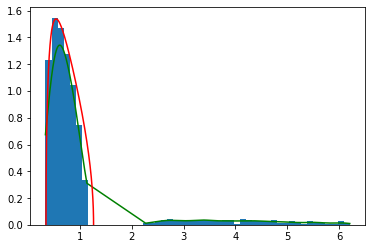

In [9]:
def getRndCov(nCols, nFacts): #nFacts - contains signal out of nCols
    w = np.random.normal(size=(nCols, nFacts))
    cov = np.dot(w, w.T) #random cov matrix, however not full rank
    cov += np.diag(np.random.uniform(size=nCols)) #full rank cov
    return cov

def cov2corr(cov):
    # Derive the correlation matrix from a covariance matrix
    std = np.sqrt(np.diag(cov))
    corr = cov/np.outer(std,std)
    corr[corr<-1], corr[corr>1] = -1,1 #for numerical errors
    return corr

alpha, nCols, nFact, q = .995, 1000, 100, 10
cov = np.cov(np.random.normal(size=(nCols*q, nCols)), rowvar=0) #size = (1000*10,1000)
cov = alpha*cov+(1-alpha)*getRndCov(nCols, nFact) # noise + signal
corr0 = cov2corr(cov)
eVal01, eVec01 = getPCA(corr0)

#find the variance of the matrix with signal
#######################
from sklearn.neighbors import KernelDensity

def fitKDE(obs, bWidth=.15, kernel='gaussian', x=None):
    #Fit kernel to a series of obs, and derive the prob of obs
    # x is the array of values on which the fit KDE will be evaluated
    #print(len(obs.shape) == 1)
    if len(obs.shape) == 1: obs = obs.reshape(-1,1)
    kde = KernelDensity(kernel = kernel, bandwidth = bWidth).fit(obs)
    #print(x is None)
    if x is None: x = np.unique(obs).reshape(-1,1)
    #print(len(x.shape))
    if len(x.shape) == 1: x = x.reshape(-1,1)
    logProb = kde.score_samples(x) # log(density)
    pdf = pd.Series(np.exp(logProb), index=x.flatten())
    return pdf

# find max random eVal by fitting Marcenko's dist
# and return variance
def findMaxEval(eVal, q, bWidth):
    out = minimize(lambda *x: errPDFs(*x), x0=np.array(0.5), args=(eVal, q, bWidth), bounds=((1E-5, 1-1E-5),))
    print("found errPDFs"+str(out['x'][0]))
    if out['success']: var = out['x'][0]
    else: var=1
    eMax = var*(1+(1./q)**.5)**2
    return eMax, var

#fitting the marcenko-pastur pdf - find variance - Fit error
#
#Error Sum of Squares. SSE is the sum of the squared differences between each observation 
#and its group's mean. It can be used as a measure of variation within a cluster.
def errPDFs(var, eVal, q, bWidth, pts=1000):
    var = var[0]
    pdf0 = mpPDF(var, q, pts) #theoretical pdf
    pdf1 = fitKDE(eVal, bWidth, x=pdf0.index.values) #empirical pdf
    sse = np.sum((pdf1-pdf0)**2)
    print("sse:"+str(sse))
    return sse 

###############

eMax0, var0 = findMaxEval(np.diag(eVal01), q, bWidth=.15)

pdf0 = mpPDF(var0, q=10, pts=1000)
fig = plt.figure()
ax  = fig.add_subplot(111)
ax.hist(np.diag(eVal01), density = True, bins=50) # Histogram the eigenvalues
pdf2 = fitKDE(np.diag(eVal01), bWidth=.15) #empirical pdf
plt.plot(pdf2.keys(), pdf2, color='g', label="Eigenvalues of random-matrix with signal")
plt.plot(pdf0.keys(), pdf0, color='r', label="Marcenko-Pastur pdf")
plt.show()

Red line is theoretical pdf, green line is best fit line of empirical eigenvalues using fitKDE() (empirical pdf).

It is also possible to find best value for parameter bwidth in fitKDE() by doing a grid-search over possible values.

## Marcheko-Pastur in CNNs

The weight-watcher project(https://pypi.org/project/WeightWatcher/) uses the Marchekno-Pastur distribution to accuratly predict which CNN performs better by analyzing the fat tails of the eigenvalue distribution. 

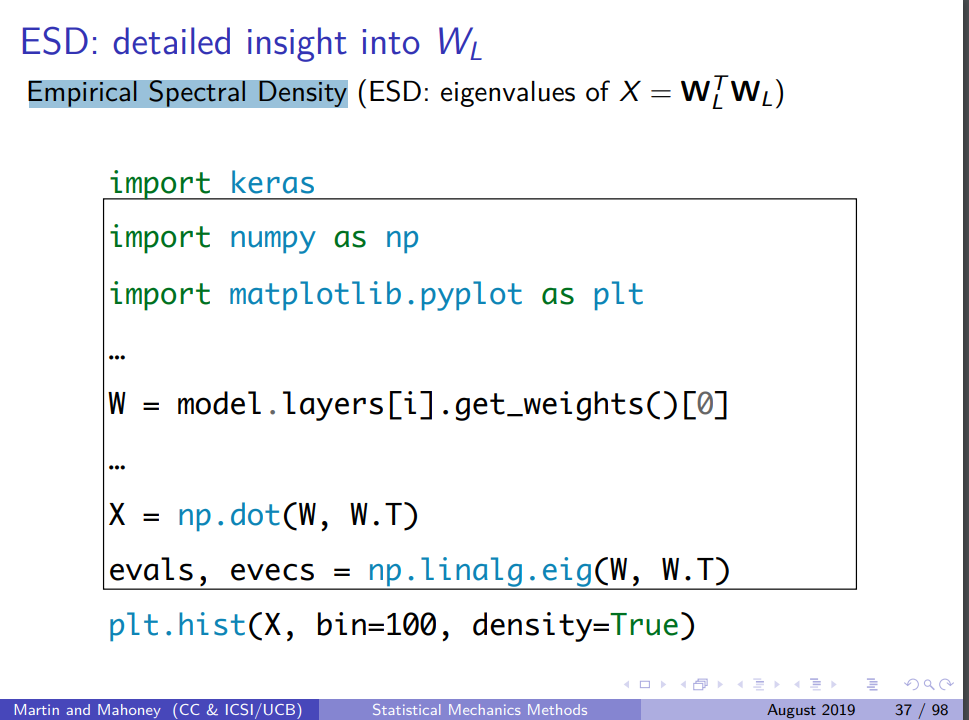
<img src="Empirical_Spectral_density2.png">
<img src="Empirical_Spectral_density3.png">
<img src="Empirical_Spectral_density4.png">
<img src="Empirical_Spectral_density5.png">

source: https://www.stat.berkeley.edu/~mmahoney/talks/dnn_kdd19_fin.pdf

<img src="4cd1c8fad0a6be9f-image-looney-gif-gif-dumbledore-s-army-role-play-wiki-fandom.gif">